# Selection Algorithm. Building block for LCU.

This building block construct the selection process for matrices of 1 qubit (at this moment).

In [2]:
from qiskit.circuit.library.standard_gates import XGate, YGate, ZGate, IGate, PhaseGate
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, Aer, transpile, assemble
import numpy as np
from py_functions.SP import State_Preparation as sp

In [3]:
info = {'I':1, 'X':0.5, 'Y':0.5j, 'Z': 0}
#info = {'II': 1, 'IX': 0, 'IY': 0, 'IZ': 0,
#        'XI': 0, 'XX': 1, 'XY': 0, 'XZ': 0, 
#        'YI': 0, 'YX': 0, 'YY': 0, 'YZ': 0, 
#        'ZI': 0, 'ZX': 0, 'ZY': 0, 'ZZ': 0,}

## With pauli decomposition:
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Z = np.array([[1,0],[0,-1]])
Y = np.array([[0, -1j],[1j,0]])

In [38]:
def give_pauli(str):

    if str == 'I':
        return np.array([[1,0],[0,1]])
    elif str == 'X':
        return np.array([[0,1],[1,0]])
    elif str == 'Y':
        return np.array([[0, -1j],[1j,0]])
    elif str == 'Z':
        return np.array([[1,0],[0,-1]])
    else:
        init = 1
        for i in str:
            if init == 1:
                matrix = give_pauli(i)
                init = 2
            else:
                matrix = np.kron(matrix, give_pauli(i))
        return matrix

def give_phase(value):
    if value == 0:
        return 0
    elif isinstance(value, complex):
        if value.imag == 0:
            if value.real < 0:
                return np.pi
            else:
                return 0
        else:
            if value.imag > 0:
                return np.pi / 2
            elif value.imag < 0:
                return -np.pi / 2
    elif isinstance(value, (int, float)):
        if value < 0:
            return np.pi
        else:
            return 0
    else:
        return None

In [32]:
def select_circuit(matrix_info):

    keys = list(matrix_info.keys())
    num_qubits = len(keys[0])
    num_control_qubits = int(np.log2(len(keys)))

    qc_select = QuantumCircuit(int(num_qubits+num_control_qubits), name="Select")

    number_logic = 0 # variable to apply the xgates to the control unitaries.

    for i in matrix_info.keys():
        qc_aux = QuantumCircuit(num_qubits, name=" {}  ".format(i))
        opt = Operator(give_pauli(i))
        qc_aux.unitary(opt, list(np.arange(0,num_qubits)))
        Ui = qc_aux.control(num_control_qubits)

        binary_number = '{0:b}'.format(number_logic).zfill(num_control_qubits)

        ######## Circuit Implementation
        ### Logic implementation
        iter = 0
        for j in binary_number:
            if j == '0':
                qc_select.x(iter)
            iter = iter + 1

        #### Add the quantum operator
        P = PhaseGate(give_phase(matrix_info[i])).control(num_control_qubits-1)
        qc_select.append(P, list(np.arange(0, num_control_qubits)))
        qc_select.append(Ui, list(np.arange(0, num_qubits+num_control_qubits)))

        ### Logic implementation inverse
        iter = 0
        for j in binary_number:
            if j == '0':
                qc_select.x(iter)
            iter = iter + 1

        ######## Finish implemention
        qc_select.barrier()

        number_logic = number_logic + 1
    
    return qc_select

In [33]:
qc_select = select_circuit(info)

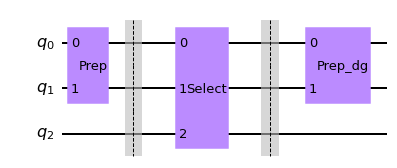

In [35]:
#prob = [1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
prob = [1,0.5,0.5,0]

prep = sp.state_preparation(prob, 0)
qc_prep = QuantumCircuit(2, name="Prep")
qc_prep.append(prep, [0,1])

prep_dagger = qc_prep.inverse()

qc = QuantumCircuit(3)

qc.append(qc_prep, [0,1])
qc.barrier()

qc.append(qc_select, [0,1,2])

qc.barrier()
qc.append(prep_dagger, [0,1])

qc.draw('mpl')

In [36]:
import qiskit.quantum_info as qi

op = qi.Operator(qc).reverse_qargs()
array = op.data

def clean_matrix(matrix, threshold=0.01):
    cleaned_matrix = np.copy(matrix)
    for i in range(cleaned_matrix.shape[0]):
        for j in range(cleaned_matrix.shape[1]):
            element = cleaned_matrix[i, j]
            # Verifica si el valor absoluto del elemento es menor que el umbral
            if np.abs(element) < threshold:
                cleaned_matrix[i, j] = 0
            else:
                # Truncar las partes real e imaginaria a dos decimales
                real_part = np.round(element.real, 2)
                imag_part = np.round(element.imag, 2)
                cleaned_matrix[i, j] = real_part + 1j * imag_part
    return cleaned_matrix

cleaned_example_matrix = clean_matrix(array)

print(cleaned_example_matrix[:4,:4])

[[ 0.5 +0.j  0.5 +0.j -0.35+0.j  0.35+0.j]
 [ 0.  +0.j  0.5 +0.j  0.35+0.j -0.35+0.j]
 [-0.35+0.j  0.35+0.j  0.5 +0.j  0.5 +0.j]
 [ 0.35+0.j -0.35+0.j  0.5 +0.j  0.  +0.j]]
